### Generate k-means datasets for practice
### This tool can also dirty up the data, so it generates datasets that are good for practicing clean-up exercises
#### Note the 2 kinds of dirty data: devious and not so devious.

### Bill Nicholson
### nicholdw@ucmail.uc.edu

In [1]:
from sklearn.cluster import KMeans
import json
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns
import shutil
from collections import OrderedDict
import colorsys
from random import randrange
from datetime import timedelta
from datetime import *
from random import normalvariate
import os
from matplotlib.ticker import MultipleLocator

In [2]:
def log(msg, fileName, mode):
    # mode: 'w' = write, 'a+' = append
    with open('fileName.txt', 'w') as f:
        print('Filename:', filename, file=f)
        f.close()

In [3]:
# https://stackoverflow.com/questions/470690/how-to-automatically-generate-n-distinct-colors/30881059#30881059
def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
        #print("get_colors(", num_colors, "): Computed colors:", colors)
    return colors

In [4]:
def computeEuclideanDistance(p1, p2):
    euclideanDistance = sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    return euclideanDistance

In [5]:
def targetClusterToString(targetCluster):
    toString = ""
    delimiter = ""
    for key in targetCluster.keys():
        toString += delimiter + key + ":" + str(targetCluster[key])
        delimiter = "-"
    return "(" + toString + ")"

In [6]:
def getDeviousDirtyData():
    return [0, None, 1, np.NaN, " ", "Missing", "None"]

In [7]:
def dirtyUpTheData(dataPoint, beDevious = True):
    '''
    Change a data value to some dirty value
    :param dataPoint the value to dirty up
    :beDevious whether or not to use dirty values than can't be commonly cleaned with dropna: "Missing" in quotes, "None" in quotes, etc.
    '''
    if random.randint(0,100) > 95:
        #howMessedUp = random.randint(0,3)
        # There's some devious values in here that dropna will not catch!
        if beDevious:
             # Remember the None constant in a numeric column is a float and will come back from the CSV file as NaN
            tmp = random.choice(getDeviousDirtyData()) 
        else:
            tmp = random.choice([None, np.NaN,])
    else:
        tmp = dataPoint
    return tmp

In [8]:
def getRandomDate(startDateString, endDateString):
    """
    This function will return a random datetime between two datetime objects.
    Just the date, not the time.
    """
    startDate = datetime.strptime(startDateString, '%Y-%m-%d')
    endDate = datetime.strptime(endDateString, '%Y-%m-%d')
    deltaDays = endDate - startDate
    #print(deltaDays, type(deltaDays))
    randomDays = randrange(deltaDays.days)
    return (startDate + timedelta(days = randomDays)).date()

In [9]:
# https://stackoverflow.com/questions/35472461/select-one-element-from-a-list-using-python-following-the-normal-distribution
def normal_choice(lst, mean=None, stddev=None):
    '''
    Pick an item from a list using a normal distribution
    This is more fun than randomly picking, which results in a uniform distribution
    '''
    if mean is None:
        # if mean is not specified, use center of list
        mean = (len(lst) - 1) / 2

    if stddev is None:
        # if stddev is not specified, let list be -3 .. +3 standard deviations
        stddev = len(lst) / 6

    while True:
        index = int(normalvariate(mean, stddev) + 0.5)
        if 0 <= index < len(lst):
            return lst[index]

In [10]:
def cleanDataFrame(myDF, columnsToConsider = None):
    '''
    Take out the yucky data
    https://www.w3schools.com/python/pandas/ref_df_dropna.asp
    '''
    if columnsToConsider != None:
        myDF.dropna(subset = columnsToConsider, inplace = True)
    else:
        myDF.dropna(inplace = True)

    # create boolean mask
    dd = getDeviousDirtyData()
    mask = myDF.isin(dd).any(axis=1)

    # invert mask and filter dataframe
    cleanDF = myDF[~mask]        
    #print("-------------------")
    #print("cleanDataFrame():")
    #print(cleanDF.info())
    #print(cleanDF.describe())
    #print(cleanDF.head())
    #print("-------------------")
    return cleanDF

In [11]:
def mkdir(dirName):
    if not os.path.exists(dirName):
        os.makedirs(dirName)

In [12]:
def verbose(message):
    #print(message)
    pass

In [13]:
def generate_random_points(centerX, centerY, radius, numPoints):
    points = []
    for i in range(numPoints):
        # Generate a random angle in radians
        angle = random.uniform(0, 2 * math.pi)
        # Generate a random distance from the center
        r = random.uniform(0, radius)
        # Convert polar coordinates to Cartesian coordinates
        x = centerX + r * math.cos(angle)
        y = centerY + r * math.sin(angle)
        points.append((x, y))
    return points

In [14]:
def processADataset(file):
    floatingPointDataTypes = ["float", "double", "floating point", "f", "d"]
    intDataTypes = ["int", "integer", "i"]
    targetCentroidColumnName = "Target Centroid"
    path = "./"
    mode = "w"
    mySeed = 42                # Default
    myDistribution = "normal"  # Default
    logFile = None
    logFileName = None
    mySigma = 100            # Wild guess
    makeItDirty = False
    #print("seed =", file["seed"])
    if file.get("seed") != None: mySeed = int(file["seed"])
    if file.get("sigma") != None: mySigma = int(file["sigma"])
    if file.get("totalpoints") != None: numberOfRows = int(file["totalpoints"])
    if file.get("makeitdirty") != None: 
        tmp = file["makeitdirty"]
        if tmp.lower() in ['true', '1', 't', 'y', 'yes', 'yeah', 'yup', 'certainly', 'uh-huh', 'ok', '-1']:
            makeItDirty = True
        else:
            makeItDirty = False
    # Gaussian doesn't work so don't use it
    #if file.get("distribution") != None: myDistribution = file["distribution"]
    random.seed(mySeed)
    columnsToCluster = OrderedDict()
    optimalClusters = int(file["optimal clusters"])
    targetClusters = []  # Will be populated as a list of dictionaries. Each sub dictionary is a point on the graph (x,y)
    fileName = file["fileName"]
    print("-----------------", fileName, "------------------")
    mkdir(fileName)
    path = "./" + fileName + "/"
    logFileHandle = open(path + fileName + '.txt', 'w') 
    print("Creating", fileName + ".csv", "optimal clusters = ", optimalClusters, file = logFileHandle)
    print("makeitdirty =", makeItDirty, file = logFileHandle)
    print("seed =", mySeed, file = logFileHandle)
    print("distribution =", myDistribution, file = logFileHandle)
    print("total points =", numberOfRows, file = logFileHandle)
    if myDistribution == "gaussian": print("sigma =", mySigma, file = logFileHandle)
    headerRow = [str(x) for x in file["columns"].keys()]
    print("Header row = ", headerRow, file = logFileHandle)
    # We can nest with/open statements! cool!
    with open(path + fileName + " with solution" + ".csv", mode) as DatasetWithSolution:
        with open(path + fileName + ".csv", mode) as Dataset:
            if mode == "w":
                DatasetWithSolution.write(",".join(headerRow) + "," + targetCentroidColumnName); DatasetWithSolution.write("\n")
                Dataset.write(",".join(headerRow)); Dataset.write("\n")
            for column in file["columns"]:
                if column in file["columns to cluster"]:
                    columnsToCluster[column] = file["columns"][column]
            print("Columns to cluster:", columnsToCluster, file = logFileHandle)
            if columnsToCluster == []:
                raise Exception("No columns to cluster were found in the meta data.")
            # Compute the centroids around which the clusters will form
            keyNumber = 0
            numberOfClusters = len(columnsToCluster)
            multipliers = list(range(1, optimalClusters + 1))
            for i in range(0, int(optimalClusters)):
                # we need a randomly generated (x, y) for the cluster.
                # x and y are the two columns we are operating on as specified in "columns to cluster" in the meta data file
                point = OrderedDict()
                verbose("Computing coordinates for " + str(optimalClusters) + " clusters")
                #print("multipliers:", multipliers)
                if len(multipliers) > 1:
                    multiplier = random.sample(multipliers, 1)[0]
                    multipliers.remove(multiplier)
                else:
                    multiplier = multipliers[0]
                for key in columnsToCluster.keys():
                    keyNumber = keyNumber + 1
                    dataType = "int"   # Assume it's int until we learn differently
                    decimalPlaces = 2
                    if columnsToCluster[key].get("datatype") != None:
                        dataType = columnsToCluster[key]["datatype"]
                    if columnsToCluster[key].get("decimalplaces") != None:
                        decimalPlaces = columnsToCluster[key]["decimalplaces"]
                    # We need some random value in the range (max,min) that is sufficiently far enough away list the other clusters we are generating here
                    # Nudge the points away from the edges
                    if dataType.lower() in intDataTypes:
                        max = int(columnsToCluster[key]["max"])
                        min = int(columnsToCluster[key]["min"])
                        featureRange = int(max) - int(min)
                        increment = (featureRange/(numberOfClusters + 1))
                        point[key] = min + (multiplier * increment)
                        #print("point[key] = ", point[key], "key =", key, "max = ", max, "min =", min, "featureRange =", featureRange, "increment =", increment)
                        
                    elif dataType.lower() in floatingPointDataTypes:
                        max = float(columnsToCluster[key]["max"])
                        min = float(columnsToCluster[key]["min"])
                        featureRange = abs(float(max)) - abs(float(min))
                        lower = min + (featureRange * .23)
                        upper = max - (featureRange * .23)
                        #print("key", key, "min", min, "max", max, "upper", upper, "lower", lower)
                        #point[key] = random.uniform(lower, upper)
                        increment = (featureRange/(numberOfClusters + 1))
                        point[key] = min + (multiplier * increment)
                        #print("point[key] = ", point[key], "key =", key, "max = ", max, "min =", min, "featureRange =", featureRange, "increment =", increment)

                    #print("key =", key, "max = ", max, "min =", min, "featureRange =", featureRange, "featureMiddle =", featureMiddle)
                    #print("upper =", upper, "lower =", lower, "co-ordinate =", point[key]) 
                #print("target cluster:", point)
                targetClusters.append(point)

            print("Target clusters computed to be:", file = logFileHandle)
            for targetCluster in targetClusters:
                print(targetCluster, file = logFileHandle)
            for rowNumber in range(0, int(numberOfRows/optimalClusters)):
                for i in range(0, len(targetClusters)):
                    row = OrderedDict()  # The row of data we will write to the CSV file at the bottom of this loop
                    for columnName in file["columns"]:
                        # column is a dictionary
                        #print(column, ":", file["columns"][column])
                        column = file["columns"][columnName]
                        if chooseFromList := column.get("choosefromlist") != None:    # Walrus operator!
                            #row[columnName] = random.choice(column["choosefromlist"])
                            row[columnName] = normal_choice(column["choosefromlist"])
                        else:
                            # Do not convert from string, yet. We don't know what data type we are working with. Could be a date.
                            max = column["max"]
                            min = column["min"]
                            dataType = "int"
                            #print("Looking for datatype in ", column)
                            if column.get("datatype") != None:
                                dataType = column["datatype"]
                                #print("Found datatype in", column, ", set to", dataType)
                            decimalPlaces = 2
                            if column.get("decimalplaces") != None:
                                decimalPlaces = column["decimalplaces"]
                            increment = column["increment"]
                            if dataType.lower() in floatingPointDataTypes:
                                value = round(random.uniform(float(min), float(max)), decimalPlaces)
                                #print("found float data type in ", column, "generated value =", value)
                            elif dataType.lower() in intDataTypes:
                                value = random.randint(int(min), int(max))
                            elif dataType == "date":
                                value = getRandomDate(str(min), str(max))
                            elif dataType == "time":
                                # ToDo: Not implemented, yet.
                                pass
                            else:
                                print("Invalid Data Type (", datatype, ")")
                            row[columnName] = value   # Don't make it a string! 
                    # Now we have a randomly generated row but we do not know if it's near any of our centroid points
                    #print("before:", row)
                    newValues = dict()
                    randomTargetCluster = random.choice(targetClusters)
                    row["Target Cluster"] = targetClusterToString(randomTargetCluster)
                    for column in columnsToCluster.keys():
                        #x = row[column]
                        # Get the vaules of the centroid, then we will nudge the values in our current row to be inthe neighborhood of that point
                        newValues[column] = randomTargetCluster[column]
                    for key in newValues.keys():
                        if myDistribution == "normal":
                            increment = (newValues[key] * random.uniform(-.2, .2))
                            # At this time the only data types for cluster dimensions are int and float
                            #print("row[",key,"]:", row[key], type(row[key]), ", ",  isinstance(row[key], int))
                            if isinstance(row[key], int):
                                row[key] = int(newValues[key] + increment)
                            else:
                                # ToDo Need to round here according to decimalplaces value in the metadata, not hard-coded to 2
                                row[key] = round(float(newValues[key] + increment), 2)
                        elif myDistribution == "gaussian":
                            mu = 5  #randomTargetCluster[key]
                            row[key] = newValues[key] + (int(random.gauss(mu, sigma)))                           
                        if random.random() > .90:
                            randomness = int(row[key] * random.random()) * random.randint(-1, 1)
                            tmp = row[key] + randomness
                            #print("row =", row, "\n  key =", key, "row[key] =", row[key], "randomness =", randomness, tmp =", tmp)
                            if tmp >= int(file["columns"][key]["min"]) and tmp <= int(file["columns"][key]["max"]):
                                row[key] = tmp
                                #print("Adding ", increment, "to get", row[key] + tmp)
                    #print("after:", row)
                    rowString = ""
                    rowStringWithSolution = ""
                    comma = ""
                    #print(row)
                    #break
                    for key in row.keys():
                        if makeItDirty and key != "Target Cluster":
                            tmp = dirtyUpTheData(row[key])
                        else:
                            tmp = row[key]
                        if key == "Target Cluster":
                            rowStringWithSolution += comma + str(tmp)
                        else:
                            rowString += comma + str(tmp)
                            rowStringWithSolution += comma + str(tmp)
                            
                        comma = ","
                    DatasetWithSolution.write(rowStringWithSolution); DatasetWithSolution.write("\n")
                    Dataset.write(rowString); Dataset.write("\n")
    
    logFileHandle.close()

In [15]:
def generateDatasets(practiceDatasets):
    fileCount = 0
    for file in practiceDatasets["files"]:
        processADataset(file)
        fileCount = fileCount + 1
    print(fileCount, " datasets processed.")

### Test one of the data files we generated 

In [16]:
def testOurGeneratedDataFile(fileName, columnsToFit, cleanFirst = False):
    fileCOunt = 0
    myDF = pd.read_csv(fileName + ".csv")
    if cleanFirst:
        myDF = cleanDataFrame(myDF, columnsToFit)
    # drop all the columns except the two we are fitting to
    myDF = myDF[columnsToFit]
    myDF[columnsToFit[0]] = myDF[columnsToFit[0]].astype('float')
    myDF[columnsToFit[1]] = myDF[columnsToFit[1]].astype('float')
    print("-------------------")
    print("testOurGeneratedDataFile():")
    print("Columns to fit:", columnsToFit)
    print(myDF.info())
    print(myDF.describe())
    print(myDF.head())
    print("-------------------")        

    #print(myDF.head())
    inertias = []
    myRange = range(1,11)
    for i in myRange:
        kmeans = KMeans(n_clusters=i, n_init = 'auto')
        kmeans.fit(myDF)
        inertias.append(kmeans.inertia_)

    plt.plot(myRange, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.rcParams['figure.figsize'] = [9, 9]  # I don't know why this works but it does seem to pleasingly resize the subplots
    plt.show()

    # Scatter plot of the DataFrame overlaid with the scatter plot of the centroids (K-means)
    # We will guess there are three clusters: that guess must match the "optimal clusters" value in the meta data file
    kmeans = KMeans(n_clusters = 3, n_init = 'auto')
    #print(myDF.describe())
    kmeans.fit(myDF)

    # The labels_ property is an array of integers indicating the centroid to which each data point has been assigned.
    #print("kmeans.labels_ =", kmeans.labels_)

    fig, ax = plt.subplots()
    ax.set_ylabel(columnsToFit[1])
    ax.set_xlabel(columnsToFit[0])
    plt.scatter(myDF[columnsToFit[0]], myDF[columnsToFit[1]], c=kmeans.labels_)
    plt.yticks(rotation=90)
    plt.xticks(rotation=90)
    #y_locator = MultipleLocator(25)
    #plt.gca().yaxis.set_major_locator(y_locator)
    #x_locator = MultipleLocator(25)
    #plt.gca().xaxis.set_major_locator(x_locator)
    centroids = kmeans.cluster_centers_
    #print("Data type of centroid data:", type(centroids))
    print("Actual shape of centroid data:", centroids.shape)
    print("Actual centroids computed by fit method:")
    for centroid in centroids:
        print(type(centroid), centroid)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 160, c=get_colors(len(centroids))) # color = myColors)
    plt.show()

    # Save a a copy of our definitive centroids for possible classification later.
    happyCentroids = kmeans.cluster_centers_    

    # Plot all the points in the same color just to get a feel for the points without classificaiton
    fig, ax = plt.subplots()
    ax.set_ylabel(columnsToFit[1])
    ax.set_xlabel(columnsToFit[0])
    plt.scatter(myDF[columnsToFit[0]], myDF[columnsToFit[1]])
    #plt.yticks(rotation=90)
    plt.xticks(rotation=90)
    y_locator = MultipleLocator(25)
    plt.gca().yaxis.set_major_locator(y_locator)
    #x_locator = MultipleLocator(25)
    #plt.gca().xaxis.set_major_locator(x_locator)
    plt.show()

    # Would be interesting: plot points in each classifications in a different color using the original centroids in the CSV file.

In [17]:
def exploreACSVFileWithDirtyData(fileName, cleanFirst = False):
    myDF = pd.read_csv(fileName + ".csv")
    print(myDF.info())
    print(myDF.describe())
    print(myDF.shape)

----------------- houses ------------------
----------------- manufacturing history ------------------
----------------- CarSales ------------------
----------------- PowerToolCollection ------------------
----------------- BankDeposits ------------------
----------------- KielLockCommercialTraffic ------------------
----------------- Brownville Food Pantry For Deer ------------------
----------------- Popular Search Phrases by Date ------------------
----------------- Produce Deliveries ------------------
9  datasets processed.
-------------------
testOurGeneratedDataFile():
Columns to fit: ['total miles', 'sale price']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 411 entries, 0 to 497
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   total miles  411 non-null    float64
 1   sale price   411 non-null    float64
dtypes: float64(2)
memory usage: 9.6 KB
None
       total miles     sale price
count   411.000000  

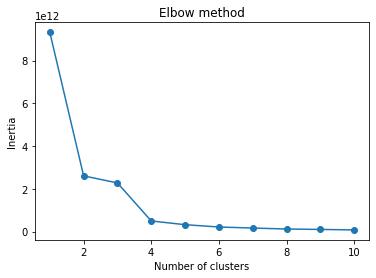

Actual shape of centroid data: (3, 2)
Actual centroids computed by fit method:
<class 'numpy.ndarray'> [1.66887417e+01 1.56020384e+05]
<class 'numpy.ndarray'> [4.74700000e+01 5.28735271e+05]
<class 'numpy.ndarray'> [3.44187500e+01 3.42066677e+05]


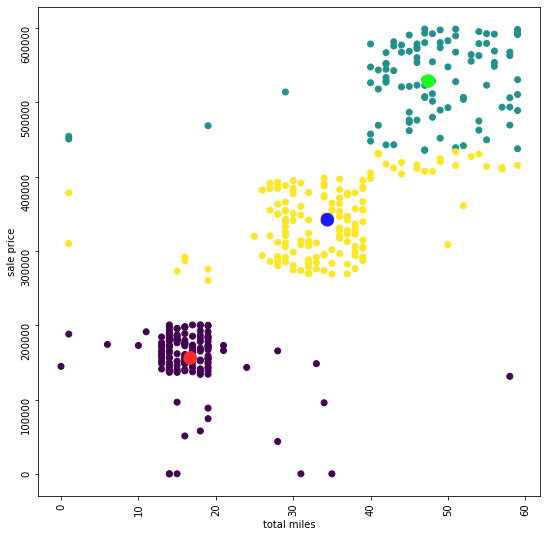

Locator attempting to generate 26346 ticks ([-29950.0, ..., 628675.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 26346 ticks ([-29950.0, ..., 628675.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 26346 ticks ([-29950.0, ..., 628675.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 26346 ticks ([-29950.0, ..., 628675.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 26346 ticks ([-29950.0, ..., 628675.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 26346 ticks ([-29950.0, ..., 628675.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 26346 ticks ([-29950.0, ..., 628675.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 26346 ticks ([-29950.0, ..., 628675.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 26346 ticks ([-29950.0, ..., 628675.0]), which exceeds Locator.MAXTICKS (1000).
L

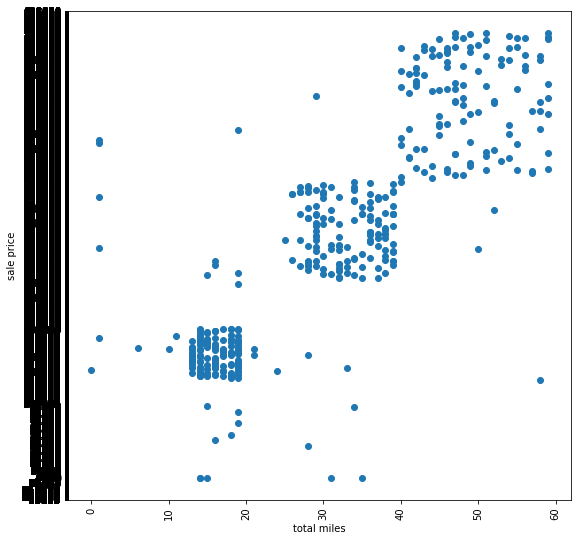

In [18]:
if __name__ == "__main__":
    #fileHandle = open("PracticeDatasetsMetaData.json")
    fileHandle = open("PracticeDatasetsMetaData - Full Version.json")
    practiceDatasets = json.load(fileHandle)
    #print(practiceDatasets)
    generateDatasets(practiceDatasets)
    #testOurGeneratedDataFile("./manufacturing history/manufacturing history", ["total cost", "percentage rejected"], cleanFirst = True)
    #testOurGeneratedDataFile("./houses/houses", ["square feet", "annual property tax"], cleanFirst = True)
    #testOurGeneratedDataFile("./PowerToolCollection/PowerToolCollection", ["cost", "hours of use"], cleanFirst = True)
    testOurGeneratedDataFile("./carsales/carsales", ["total miles", "sale price"], cleanFirst = True)
    #exploreACSVFileWithDirtyData("./carsDirtyData/carsDirtyData")